# Run Pharaglow 

In [1]:
%matplotlib inline
# %matplotlib qt

import numpy as np
import os
import pandas as pd
import shutil
import timeit

# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### input parameters

In [2]:
### CHANGE FILE/DIRECTORY NAMES
# parameterfile = "../AnalysisParameters_1x"
# inPath = "/home/mscholz/Dropbox (Scholz Lab)/Shared/Data/MS0006_0_1000frames"
# outPath = "/home/mscholz/Desktop/TestOutput_MS0006/"
# lawnPath = None #"/opt/data/Lawns/"
# movie = "MS0006_0_1000frames"
# movieID = movie[-6:]
# nWorkers = 5

# Write the path of the directories where
# > is the parameters file
parameterfile = '/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/Linking/EB0068_parameters.txt'
# > are the tiff files
inPath = '/home/nif/Desktop/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c/'
# > will be saved the pharaglow output files
outPath = f'/home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test'
# > is the tiff file with the bacterial lawn (if no lawn: None)
lawnPath = None #"/opt/data/Lawns/"

# Set the names of the tiff files folder and the identification number of the recording
movie = "EB0068"
movieID = movie # the ID should be AA1000
# movieID = movie[-6:]

# Set the number of processing cores used for the analysis
nWorkers = 20

# # Inactivate (False) or activate (True) the debug mode
debug=True

In [3]:
# Check paths

npaths = {'parameter file': parameterfile,
          'inPath':inPath,
          'outPath': outPath}

for key, value in npaths.items():    
    if os.path.exists(value):
        print(f'{key}: {value}')
    else:
        print(f"Warning! The path for {key} doesnt exist: {value}")

parameter file: /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/Linking/EB0068_parameters.txt
inPath: /home/nif/Desktop/data/Elsa/1_Rawdata/20201217_solenoid_mutants/recording/EB0068c/
outPath: /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test


### Add a logger

In [4]:
def log_setup(name, level, fname):
    '''This function will setup a logger with the name and level you pass as input'''
    
    # start a logger
    logger = logging.getLogger(name)
    # set a formatter to manage the output format of our handler
    formatter = logging.Formatter('%(asctime)s | %(name)s |  %(levelname)s: %(message)s')
    
    # set the level passed as input, has to be logging.LEVEL not a string
    # until we do so mylog doesn't have a level and inherits the root logger level:WARNING
    logger.setLevel(level)

    # add a handler to send INFO level messages to console
    # console_handler = logging.StreamHandler()
    # console_handler.setLevel(logging.INFO)
    # logger.addHandler(console_handler)  
    
    # add a handler to send DEBUG level messages to file
    # all you need is a file name I added the 'w' so each time a new file will be created
    # without it the messagges will be appended to the same file
    file_handler = logging.FileHandler(fname)
    # file_handler = logging.FileHandler(fname,'w')
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # return the logger object
    return logger

In [5]:
# Date of the analysis
from datetime import date
today = date.today()
today = today.strftime("%Y%m%d")
print(f'today is {today}')

today is 20210210


In [6]:
import logging

# # remember to uncomment these lines if you have want to set your own root logger (use once per script)
# for handler in logging.root.handlers[:]:
#    logging.root.removeHandler(handler)
# # We disabled the existing handlers after import logging so we can configure the root logger as we want

# We set the level to root logger level to WARNING
logging.basicConfig(level=logging.WARNING)

# set the path and the name of the log
fname = os.path.join(outPath, f'{today}_{movieID}_pharaglow_log.txt')

# set the logger
logger = log_setup('PharaGlow', logging.DEBUG, fname)
logger.info(f'The log file is stored as {fname}')


#  Source: https://climate-cms.org/2018/10/05/introduction-to-python-logging.html

INFO:PharaGlow:The log file is stored as /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/20210210_EB0068_pharaglow_log.txt


### Creating new file names

In [7]:
fname = os.path.join(inPath,"*.tiff")
outfile = os.path.join(outPath, movieID+"_{}_{}.json")
logger.info(f"output file would be saved as {outfile}")
saveparam = os.path.join(outPath, movieID+"_parameters")
logger.info(f"paramaters file would be saved as {saveparam}")

INFO:PharaGlow:output file would be saved as /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/EB0068_{}_{}.json
INFO:PharaGlow:paramaters file would be saved as /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/test/EB0068_parameters


### Load data

In [8]:
if debug:
    
    logger.debug('Select tiff files to analyze:')
    
    first_tiff = 1 # tiff file name/number (minimum=1)
    last_tiff = 200

    n = np.arange(first_tiff-1, last_tiff)  
    logger.debug(f'first tiff:{first_tiff}, n.min:{n.min()}')
    logger.debug(f'last tiff:{last_tiff}, n.max:{n.max()}')

DEBUG:PharaGlow:Select tiff files to analyze:
DEBUG:PharaGlow:first tiff:1, n.min:0
DEBUG:PharaGlow:last tiff:200, n.max:199


In [9]:
%%time
start = timeit.default_timer()


if lawnPath is not None and lawnPath != 'None':
    logger.info('Loading lawn file...')
    try:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.tiff')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    except Exception:
        lawnfile = os.path.join(lawnPath,movieID+'_lawn.bmp')
        lawn = pims.open(lawnfile)[0]
        binLawn = features.findLawn(lawn)
    logger.info("Lawnfile opened as 'lawn'")
else:
    lawnfile = None



# starting pharaglow
logger.info("Loading tiff files...")
rawframes = pims.open(fname)

if not debug:
    rawframes = rawframes
if debug:
    logger.debug(f"A subset of {len(n)} files will be analyzed")
    rawframes = rawframes[n]
logger.info("tiff files loaded as 'rawframes'")


logger.info(f"Loading parameters from {parameterfile}...")
with open(parameterfile) as f:
    param = json.load(f)
    f.close()
logger.info(f"parameters file loaded as 'param':{param}")



# Measure the wall time for running the current cell [s]
stop = timeit.default_timer()
logger.info(f"Loading time: {stop - start}s")  

INFO:PharaGlow:Loading tiff files...
DEBUG:PharaGlow:A subset of 200 files will be analyzed
INFO:PharaGlow:tiff files loaded as 'rawframes'
INFO:PharaGlow:Loading parameters from /home/ebonnard/Desktop/Elsa/2_PharaGlow/20201217_solenoid_mutants/EB0068/Linking/EB0068_parameters.txt...
INFO:PharaGlow:parameters file loaded as 'param':{'subtract': 0, 'smooth': 1, 'dilate': 1, 'tfactor': 0.99, 'thresholdWindow': 120, 'bgWindow': 100, 'length': 100, 'searchRange': 60, 'minimalDuration': 300, 'memory': 30, 'minSize': 600, 'maxSize': 3000, 'watershed': 100, 'widthStraight': 10, 'pad': 5, 'nPts': 200, 'linewidth': 2}
INFO:PharaGlow:Loading time: 0.48733667307533324s


CPU times: user 450 ms, sys: 39.6 ms, total: 489 ms
Wall time: 488 ms


In [10]:
# Files monitoring

# tiff files
logger.info(f"Number of tiff files: {len(os.listdir(inPath))}")

# rawframes 
logger.info(f"Number of rawframes: {len(rawframes)}")

if len(os.listdir(inPath)) != len(rawframes):
    if not debug:
        logger.warning("the number of tiff files doesn't match with the number of rawframes !")


INFO:PharaGlow:Number of tiff files: 27001
INFO:PharaGlow:Number of rawframes: 200


### Improve lawn detection if neccessary

In [11]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 1, preserve_range = True)
    thresh = threshold_li(image, initial_guess = np.median)
    binary = image > thresh*0.5
    binary = remove_small_holes(binary, area_threshold=1500, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=5000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    plt.subplot(122)
    plt.imshow(binLawn)

### Create binary masks

In [12]:
%%time
start = timeit.default_timer()

# detecting objects
logger.info('Binarizing images...')

masks = tracking.calculateMask(rawframes,
                               minSize = param['minSize'],
                               bgWindow = param['bgWindow'],
                               thresholdWindow = param['thresholdWindow'],
                               smooth =  param['smooth'],
                               subtract =  param['subtract'],
                               dilate = param['dilate'],
                               tfactor=param['tfactor'])


stop = timeit.default_timer()
logger.info(f"binary masks created ({stop - start}s)")  

INFO:PharaGlow:Binarizing images...
INFO:PharaGlow:binary masks created (0.41025803703814745s)


CPU times: user 357 ms, sys: 55.2 ms, total: 412 ms
Wall time: 411 ms


### Make sure the thresholding worked otherwise change parameters

In [13]:
# Select a rawframe to visualize
t = 300
print(f"rawframe {t} to visualize ")

if t> (len(rawframes)-1):
    print(f"Warning ! Max {len(rawframes)-1} rawframes. {t} changed to 0")
    t=0

rawframe 300 to visualize 
Warning ! Max 199 rawframes. 300 changed to 0


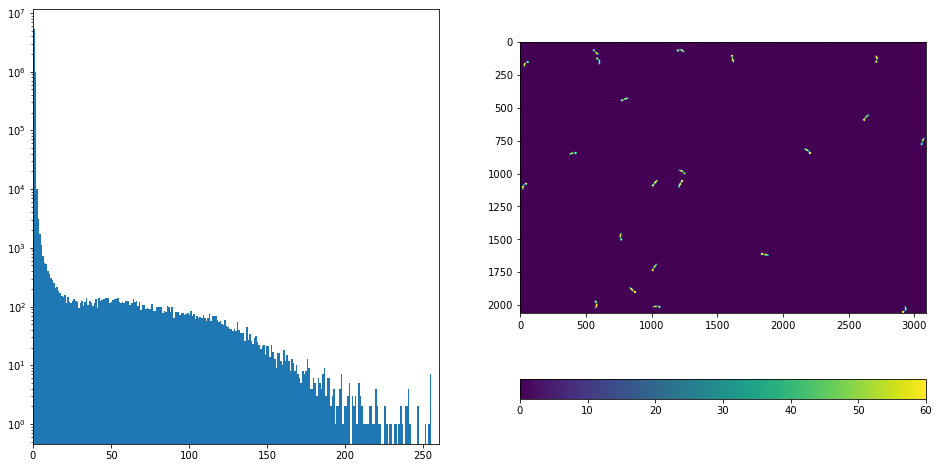

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(121)
# Plot the histogram of the pixel intensity values of the rawframe
plt.hist(rawframes[t].ravel(), bins=256, log=True)
plt.xlim(0, 260) # xlim for 8 bits image

plt.subplot(122)
# Adjust the color limit for the rawframe for vizualisation only
color = (0,60) # 0<=color<=255 for 8 bits image
# color = None 
plt.imshow(rawframes[t],clim = color)
plt.colorbar(orientation='horizontal')


False


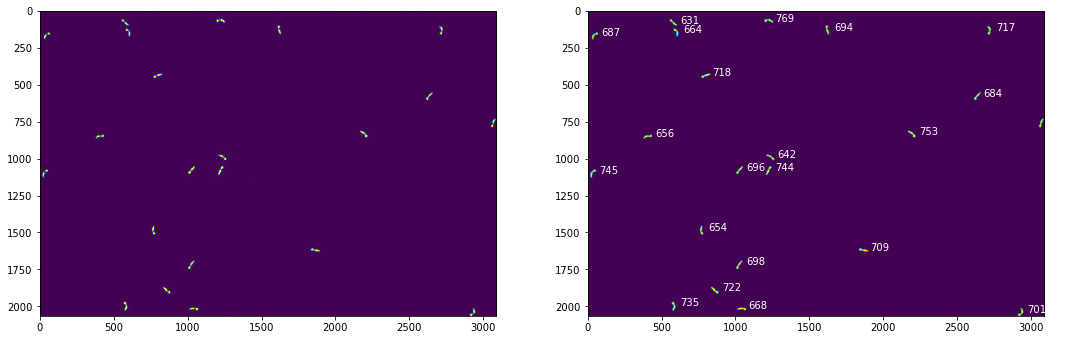

In [15]:
from skimage.measure import label, regionprops

plt.figure(figsize=(18,16))

plt.subplot(121)
# Show the rawframe
plt.imshow(rawframes[t],clim= color)#+lawn)
if lawnfile is not None:
    # Show the lawn
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    
plt.subplot(122)
# Show the masks and their size [px]
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
print(np.min(masks[t]))
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')


### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [16]:
import time
from multiprocessing import Pool

chunksize = 100#
logger.info(f'chunksize={chunksize}')

def parallelDetection(rawframes, masks, nWorkers):
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    #slice the movie into pieces to run
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+1, chunksize)))
    jobs = []
    for (a,b) in slices:
        print(a,b)
        jobs.append([rawframes[a:b+1], masks[a:b+1], param, a])
    # add the remainder job for things not divisible by chunksize
    jobs.append([rawframes[b:], masks[b:], param, b])
    # delete jobs of length 1
    jobs = [j for j in jobs if len(j[0])>1]
    # add last bit
    #run the parallel feature detection.
    features = []
    images = []
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(tracking.parallelWorker, jobs)):
        features.append(res[0])
        images.append(res[1])
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers))
    
    p.close()
    p.join()
    features = pd.concat(features)
    images = pd.concat(images)
    # change the image column names
    images.columns = [f"im{s}" for s in images.columns]
    # make one big dataframe
    features = pd.concat([features, images], axis = 1)
    features = features.reset_index(drop=True)
    return features

INFO:PharaGlow:chunksize=100


In [ ]:
%%time
start = timeit.default_timer()

logger.info('Detecting features...')

if nWorkers ==1 or len(rawframes) < chunksize:
    logger.info('...without parallel detection...')
    features, images = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
    features = pd.concat([features, images], axis = 1)
else:
    logger.info('...with parallel detection...')
    features = parallelDetection(rawframes, masks, nWorkers)
    

stop = timeit.default_timer()
logger.info(f"features detected ({stop - start}s)")  

INFO:PharaGlow:Detecting features...
INFO:PharaGlow:...with parallel detection...


0 100
100 200
Analyzing frames 0 to 101
Analyzing frames 100 to 200


In [ ]:
# Files monitoring
logger.info(f" Number of frames in features:{features['frame'].nunique()}")
                                                       
if len(rawframes) != len(features['frame'].unique()):
    logger.warning(f" Number of frames in features ({features['frame'].nunique()}) and the number of rawframes ({len(rawframes)}) don't match !")

In [ ]:
### Show the area of all objects

features['area'].hist(bins = 30)

logger.info(f"features.area.min():{features.area.min()}") # region.area > params['minSize']
logger.info(f"features.area.max():{features.area.max()}") # region.area < params['maxSize']

### Save features

In [ ]:
# saving features
logger.info("Saving features...")
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')
logger.info(f"features saved as {outfile.format('features', 'all')}")

# saving parameter file
logger.info("Saving parameters...")
shutil.copyfile(parameterfile, saveparam, follow_symlinks=True)
logger.info(f"parameters saved as {parameterfile}")

### Load all features 
-- only if execution was interrupted

In [ ]:
%%time
start = timeit.default_timer()

logger.info("Loading features...")
features = pd.read_json(outfile.format('features', 'all'), orient='split')

stop = timeit.default_timer()
logger.info(f"features loaded ({stop - start}s)")

In [ ]:
### test the new image storage
N=10
colnames = [f'im{i}' for i in range(int(features.iloc[N]['shapeX'])*int(features.iloc[N]['shapeY']))]
tim = util.get_im(features.iloc[N], colnames, int(features.iloc[N]['shapeX']))

plt.imshow(tim)

### Link objects to trajectories and interpolate short misses

In [ ]:
logger.info('Linking trajectories...')
logger.info(f"Parameter searchRange: {param['searchRange']}px")
logger.info(f"Parameter memory: {param['memory']}frames")

In [ ]:
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(features,param['searchRange'], memory = param['memory'])
logger.info(f"Number of trajectories after linking: {len(trajectories['particle'].unique())}")

In [ ]:
logger.info('Interpolating trajectories...')

traj = []

for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    # interpolate data but do not interpolate the images!
    traj.append(tracking.interpolateTrajectories(tmp, columns = ['x', 'y', 'shapeX', 'shapeY', 'particle']))
    
trajectories = pd.concat(traj, ignore_index = True)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

logger.info(f"Interpolation done.")

In [ ]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, colorby = 'particle', superimpose=1-masks[t],label=False);

In [ ]:
logger.info(f"Filtering out trajectories which last less than the minimal duration ({param['minimalDuration']} frames)...")
logger.info(f"Nb of trajectories before filtering: {trajectories['particle'].nunique()}")

trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
logger.info(f"Nb of trajectories after filtering: {trajectories['particle'].nunique()}")

In [ ]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, superimpose=1-masks[t], label=False);

### add the missing images to interpolated trajectories

In [ ]:
%%time
start = timeit.default_timer()


from pharaglow import tracking, run, features
# interpolate the shape parameter
def interpolate_helper(rawframes, row):
    """wrapper to make the code more readable."""
    # check if image is nan - then we insert an image from the original movie
    im_cols =  [f'im{i}' for i in range(int(row['shapeX'])*int(row['shapeY']))]
    
    if np.all(np.isnan(row[im_cols])):
        print('interpolating', row['frame'])
        im, sx0,sx1,sy0, sy1, ly, lx = tracking.fillMissingImages(rawframes, int(row['frame']), row['x'], row['y'],\
                                                   lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])
        # make the image into a pandas format and return a whole row
        im_cols =  [f'im{i}' for i in range(lx*ly)]
        # other column names
        [im_cols.append(x) for x in ['slice_x0','slice_x1','slice_y0','slice_y1', 'shapeY', 'shapeX']]
        row[im_cols] = [*list(im.ravel()),  sx0,sx1,sy0, sy1, ly, lx]
    return row

logger.info('Fill in missing images...')
trajectories = trajectories.apply(\
    lambda row: interpolate_helper(rawframes, row), axis=1)


stop = timeit.default_timer()
logger.info(f"Missing images added to interpolated trajectories ({stop - start}s)")  

### Extract lawn info

In [ ]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

### Show resulting trajectories

In [ ]:
plt.figure(figsize=(11,11))
plt.title(f"{trajectories['particle'].nunique()} trajectories detected ({movieID})")
tp.plot_traj(trajectories)
# tp.plot_traj(trajectories, superimpose=1-masks[t], label=False)

plt.savefig(os.path.join(outPath,f'{today}_{movieID}_resulting_trajectories.pdf'))  

In [ ]:
# # write trajectories to separate files.

logger.info(f"Saving {trajectories['particle'].nunique()} trajectories to separate files...")

for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    
    # write trajectories to file
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')
    
logger.info("Trajectories saved as json files.") 

# # Write trajectories to a single file
# trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)    

### check slow-down before continuing analysis

In [ ]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 1000
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    print('pid:', pid)
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print('time:', len(time))
                    v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                    #print('v:', v)
                    #print('v.iloc:', v.iloc[t0-dt:t0+dt])
                    plt.plot(time, v.iloc[t0-dt:t0+dt], 'navy', alpha=0.1)
                    vcut.append(v.iloc[t0-dt:t0+dt].values)
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
                    
    if len(vcut) >0:  
        plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
        plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
        plt.axvline(dt/30, color='k', linestyle='--')
        plt.ylabel(r"velocity ($\mu$m/s)");
        plt.xlabel("time (s)");
        plt.ylim(0,150)

### run the whole pharaglow feature extraction

In [ ]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    df_split = [d for d in df_split  if len(d)>0]
    if len(df_split) <1:
        return
    # filter zero-size jobs
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

In [ ]:
%%time
start = timeit.default_timer()

# save only minimal outputs - reduces save by approx factor 3
save_minimal = True
path = os.path.dirname(outfile)

for fn in os.listdir(path):
    file = os.path.join(path,fn)
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split')
        # create a temporary column with an image array
        traj['image'] = traj.apply(lambda row: util.get_im(row, [f'im{i}' for i in range(int(row['shapeX'])*int(row['shapeY']))],
                                            int(row['shapeX'])), axis=1)
        
        # skip invalid frames
        invalid_images = traj[[np.sum(im)==0 for im in traj['image']]].index
        if len(invalid_images)>0:
            logger.info(f'invalid images in frames {invalid_images}')
        # ignore rows where images are empty - we later will interpolate
        traj = traj.drop(invalid_images)
        if len(traj.index)<1:
            print('Skipped', file)
            continue
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = nWorkers, params = param)
        
        # get more exact entry location
        if lawnfile is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        
        # remove some columns to make the result smaller
        if save_minimal:
            tmp = tmp.drop(['Mask', 'SkeletonX', 'SkeletonY', 'ParX', 'ParY', 
                            'Xstart', 'Xend', 'Centerline', 'dCl', 'Widths', 'Contour', 'Gradient', 
                            'Kymo', 'KymoGrad', 'Similarity', 'Xtmp'], axis = 1)
        
        tmp = tmp.drop(['image'], axis = 1)
        tmp.to_json(outfile.format('results', particle_index), orient='split')

if save_minimal:
    logger.info('minimal information saved')
    
stop = timeit.default_timer()
logger.info(f"Whole pharaglow features extracted ({stop - start}s)")  

### Check if data has been analyzed

In [ ]:
# Files monitoring

files_list = os.listdir(outPath)
f1 =[]
f2 =[]

for fn in files_list:
    file = os.path.join(outPath,fn)
    if os.path.isfile(file) and f'{movieID}_trajectories_' in fn  and fn.endswith('.json'):
        if not 'all' in fn: 
            particle_index = int(fn.split('.')[0].split('_')[-1])
            f1.append(particle_index)
    if os.path.isfile(file) and f'{movieID}_results_' in fn and fn.endswith('.json'): 
        particle_index = int(fn.split('.')[0].split('_')[-1])
        f2.append(particle_index)


logger.info('trajectories.json files: %s ', len(f1))
logger.info('results.json files: %s ', len(f2))
if len(f1) != len(f2):
    logger.warning('trajectories - results: %s', set(f1).symmetric_difference(set(f2)))


In [ ]:
# Saving parameters if they have been changed (debug mode activated)
if debug:
    logger.debug(f"New parameters:{param}")
    paramPath = os.path.join(outPath, movieID + '_parameters_new.txt')
    with open(paramPath,'w') as f:
         f.write(json.dumps(param)) # use `json.loads` to do the reverse
         
    logger.debug(f"New parameters saved as {paramPath}")

In [ ]:
logger.info("PharaGlow ends here")